# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# pip install scipy==1.1.0

In [2]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from imageio import imread
from skimage.transform import resize
import datetime
import os

import matplotlib.pyplot as plt
% matplotlib inline

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
def plot_score(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/ML data /Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/ML data /Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height

def generator(source_path, folder_list, batch_size):
    #print("\n running generator ")
    #print( '\n Source path = ', source_path, '\n batch size =', batch_size )
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    #print("\n img_idx =" , img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        #print("\n num_batches =" , num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            #print("\n Processing batch = ", batch) 
            #print("\n batch: ",batch)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                #print("\n reading folder =", imgs)
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image_resized = resize(image,(120,120))
                    image_resized = image_resized/255 #(image_resized - image_resized.min())/(image_resized.max() - image_resized.min())
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            #print("\n Processing batch left after full batches" ,   )
            
            batch_size = len(folder_list) - (batch_size*num_batches)
            #print("\n batch_size: ", batch_size)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                #print("\n reading folder =", imgs)
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = resize(image,(120,120))  # resize the image 
                    image_resized = image_resized/255 # Normalize the image 

                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/ML data /Project_data/train'
val_path = '/content/drive/MyDrive/ML data /Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation , Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers 
import keras

#write your model here

model =  Sequential()

model.add(Conv3D(8,  kernel_size=(3,3,3),  input_shape=(30, 120, 120, 3),  padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16,kernel_size=(3,3,3),  padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 16)    0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
model_name = '/content/drive/MyDrive/ML data /Project_data/'+'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]



The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

### Experiment 1 - batch size = 10 , epoch= 20 , learning_rate=0.001

In [14]:
num_epochs = 20 
batch_size = 10

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - 535s 8s/step - loss: 2.8552 - categorical_accuracy: 0.2760 - val_loss: 2.7566 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00001-2.85519-0.27602-2.75660-0.21000.h5
Epoch 2/20
67/67 [==============================] - 113s 2s/step - loss: 1.5025 - categorical_accuracy: 0.3532 - val_loss: 4.0270 - val_categorical_accuracy: 0.1500

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00002-1.50252-0.35323-4.02703-0.15000.h5
Epoch 3/20
67/67 [==============================] - 124s 2s/step - loss: 1.3411 - categorical_accuracy: 0.4428 - val_loss: 4.0864 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00003-1.34109-0.44279-4.08636-0.20000.h5

Epoch 00003: ReduceLROnPlat

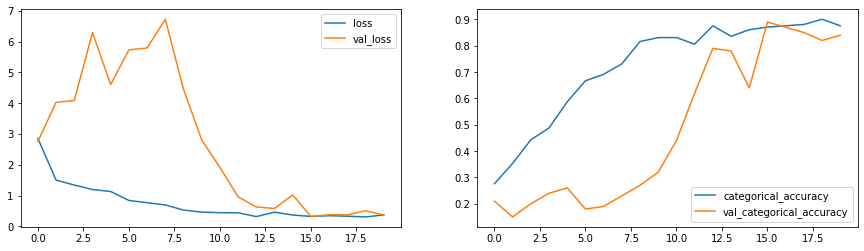

In [15]:
plot_score(history)


### Experiment 2 - batch size = 15 , epoch= 20 ,  , learning_rate=0.001



In [16]:
num_epochs = 15 
batch_size = 10

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)




Epoch 1/15
67/67 [==============================] - 109s 2s/step - loss: 0.3371 - categorical_accuracy: 0.8856 - val_loss: 0.3249 - val_categorical_accuracy: 0.8800

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00001-0.33707-0.88557-0.32494-0.88000.h5
Epoch 2/15
67/67 [==============================] - 113s 2s/step - loss: 0.2897 - categorical_accuracy: 0.8856 - val_loss: 0.2952 - val_categorical_accuracy: 0.8800

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00002-0.28974-0.88557-0.29519-0.88000.h5
Epoch 3/15
67/67 [==============================] - 111s 2s/step - loss: 0.2689 - categorical_accuracy: 0.9154 - val_loss: 0.3979 - val_categorical_accuracy: 0.8600

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00003-0.26885-0.91542-0.39794-0.86000.h5
Epoch 4/15
67/67 [==========

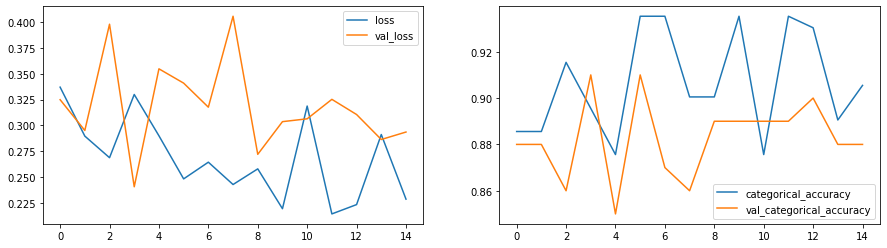

In [17]:
plot_score(history)


### Experiment 2 - batch size = 100  epoch=20




In [14]:
batch_size =  100
num_epochs = 20 

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
7/7 [==============================] - 572s 92s/step - loss: 7.7593 - categorical_accuracy: 0.1429 - val_loss: 1.6162 - val_categorical_accuracy: 0.1000

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2803_12_19.635415/model-00001-7.75931-0.14286-1.61619-0.10000.h5
Epoch 2/20
7/7 [==============================] - 590s 98s/step - loss: 4.9551 - categorical_accuracy: 0.2286 - val_loss: 1.5368 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2803_12_19.635415/model-00002-4.95509-0.22857-1.53681-0.40000.h5
Epoch 3/20
7/7 [==============================] - 566s 94s/step - loss: 3.9265 - categorical_accuracy: 0.2571 - val_loss: 1.8588 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2803_12_19.635415/model-00003-3.92653-0.25714-1.85885-0.20000.h5
Epoch 4/20
7/7 [===============

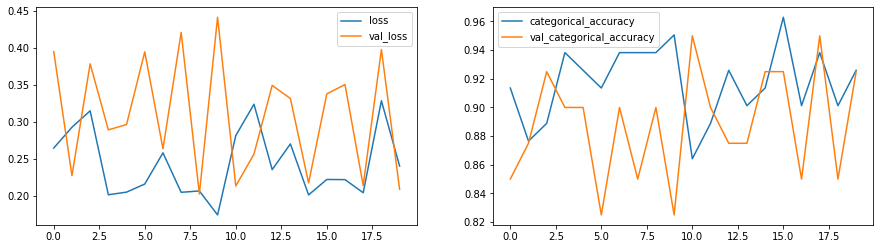

In [19]:
plot_score(history)

### Experiment 3 - batch size = 50 , epoch =20 












In [20]:
num_epochs = 20
batch_size =  50

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
14/14 [==============================] - 29s 2s/step - loss: 0.1657 - categorical_accuracy: 1.0000 - val_loss: 0.2985 - val_categorical_accuracy: 0.9000

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00001-0.16572-1.00000-0.29847-0.90000.h5
Epoch 2/20
14/14 [==============================] - 23s 2s/step - loss: 0.2592 - categorical_accuracy: 0.9048 - val_loss: 0.4097 - val_categorical_accuracy: 0.8500

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00002-0.25917-0.90476-0.40966-0.85000.h5
Epoch 3/20
14/14 [==============================] - 27s 2s/step - loss: 0.1889 - categorical_accuracy: 0.9286 - val_loss: 0.1511 - val_categorical_accuracy: 1.0000

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00003-0.18891-0.92857-0.15107-1.00000.h5
Epoch 4/20
14/14 [=============

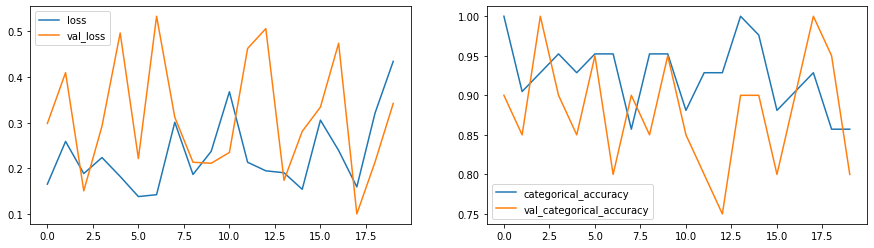

In [21]:
plot_score(history)

### Experiment 4 - batch size = 50 , epoch =20 , learning_rate=0.0001

In [22]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

num_epochs = 20
batch_size =  50

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/20
14/14 [==============================] - 29s 2s/step - loss: 0.4180 - categorical_accuracy: 0.8095 - val_loss: 0.5956 - val_categorical_accuracy: 0.7000

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00001-0.41803-0.80952-0.59559-0.70000.h5
Epoch 2/20
14/14 [==============================] - 24s 2s/step - loss: 0.3192 - categorical_accuracy: 0.8810 - val_loss: 0.3106 - val_categorical_accuracy: 0.9000

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00002-0.31922-0.88095-0.31062-0.90000.h5
Epoch 3/20
14/14 [==============================] - 28s 2s/step - loss: 0.2457 - categorical_accuracy: 0.9048 - val_loss: 0.5378 - val_categorical_accuracy: 0.9000

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00003-0.24569-0.90476-0.53777-0.90000.h5
Epoch 4/20
14/14 [=============

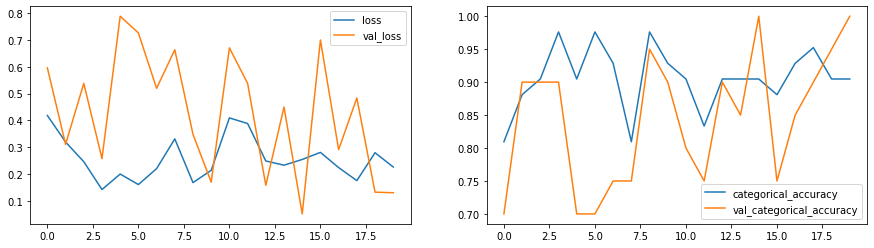

In [23]:
plot_score(history)

### Experiment 5 - batch size = 60 , epoch =20 





In [24]:
num_epochs = 20
batch_size =  60

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
12/12 [==============================] - 26s 2s/step - loss: 0.2359 - categorical_accuracy: 0.9167 - val_loss: 0.8390 - val_categorical_accuracy: 0.7500

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00001-0.23586-0.91667-0.83903-0.75000.h5
Epoch 2/20
12/12 [==============================] - 22s 2s/step - loss: 0.1432 - categorical_accuracy: 0.9444 - val_loss: 0.2460 - val_categorical_accuracy: 0.9000

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00002-0.14320-0.94444-0.24601-0.90000.h5
Epoch 3/20
12/12 [==============================] - 23s 2s/step - loss: 0.1151 - categorical_accuracy: 0.9722 - val_loss: 0.2124 - val_categorical_accuracy: 0.9500

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00003-0.11507-0.97222-0.21236-0.95000.h5
Epoch 4/20
12/12 [=============

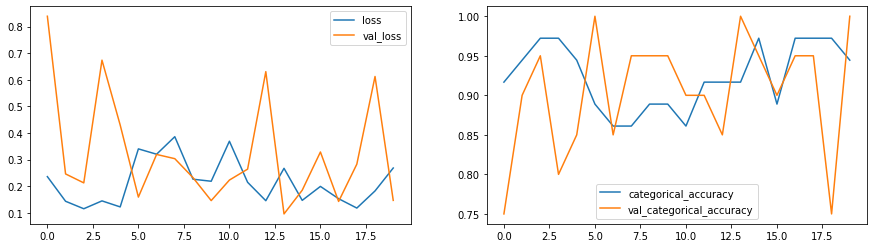

In [25]:
plot_score(history)

### Changing the Model layers -  removed layer of 8 filters and Added a new layer of 128 filters -  









In [26]:
model_2 =  Sequential()

model_2.add(Conv3D(16,kernel_size=(3,3,3),  input_shape=(30, 120, 120, 3),  padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

model_2.add(MaxPooling3D(pool_size=(2,2,2)))

# Adding this layer 
model_2.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

model_2.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_2.add(Flatten())

model_2.add(Dense(1000, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(500, activation='relu'))
model_2.add(Dropout(0.5))

#softmax layer
model_2.add(Dense(5, activation='softmax'))


In [27]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_4 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 60, 60, 32)    128       
_________________________________________________________________
activation_5 (Activation)    (None, 15, 60, 60, 32)   

### Experiment 6 with new added layers and batch size = 25 epoch = 20

In [28]:
num_epochs = 20
batch_size =  25

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history =  model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
27/27 [==============================] - 46s 2s/step - loss: 9.9778 - categorical_accuracy: 0.1481 - val_loss: 2.2185 - val_categorical_accuracy: 0.1250

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00001-9.97785-0.14815-2.21854-0.12500.h5
Epoch 2/20
27/27 [==============================] - 47s 2s/step - loss: 2.0388 - categorical_accuracy: 0.1975 - val_loss: 1.8519 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00002-2.03880-0.19753-1.85187-0.30000.h5
Epoch 3/20
27/27 [==============================] - 49s 2s/step - loss: 1.6691 - categorical_accuracy: 0.1728 - val_loss: 2.2749 - val_categorical_accuracy: 0.1750

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00003-1.66906-0.17284-2.27488-0.17500.h5
Epoch 4/20
27/27 [=============

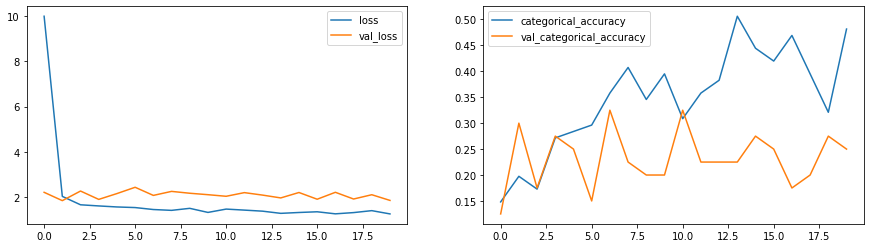

In [29]:
plot_score(history)

### Experiment 7 with new added layers and batch size = 50 epoch = 20

In [30]:
num_epochs = 20
batch_size =  50

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history =  model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
14/14 [==============================] - 24s 2s/step - loss: 1.1915 - categorical_accuracy: 0.5714 - val_loss: 1.8274 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00001-1.19154-0.57143-1.82737-0.20000.h5
Epoch 2/20
14/14 [==============================] - 25s 2s/step - loss: 1.3575 - categorical_accuracy: 0.4524 - val_loss: 1.9528 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00002-1.35755-0.45238-1.95279-0.25000.h5
Epoch 3/20
14/14 [==============================] - 24s 2s/step - loss: 1.2024 - categorical_accuracy: 0.4048 - val_loss: 1.6740 - val_categorical_accuracy: 0.1500

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00003-1.20244-0.40476-1.67401-0.15000.h5
Epoch 4/20
14/14 [=============

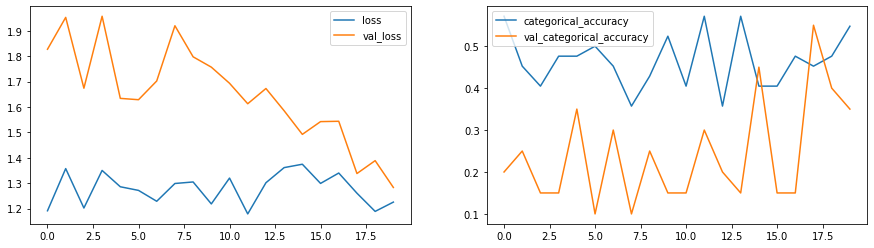

In [31]:
plot_score(history)

### Experiment 8 with new added layers and batch size = 50 epoch = 20 , learning_rate=0.0001

In [32]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

num_epochs = 20
batch_size =  50

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history =  model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
14/14 [==============================] - 26s 2s/step - loss: 1.2973 - categorical_accuracy: 0.4762 - val_loss: 1.2250 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00001-1.29728-0.47619-1.22499-0.35000.h5
Epoch 2/20
14/14 [==============================] - 27s 2s/step - loss: 1.2461 - categorical_accuracy: 0.4286 - val_loss: 1.6014 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00002-1.24606-0.42857-1.60139-0.20000.h5
Epoch 3/20
14/14 [==============================] - 27s 2s/step - loss: 1.2163 - categorical_accuracy: 0.5476 - val_loss: 1.0468 - val_categorical_accuracy: 0.5500

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00003-1.21627-0.54762-1.04685-0.55000.h5
Epoch 4/20
14/14 [=============

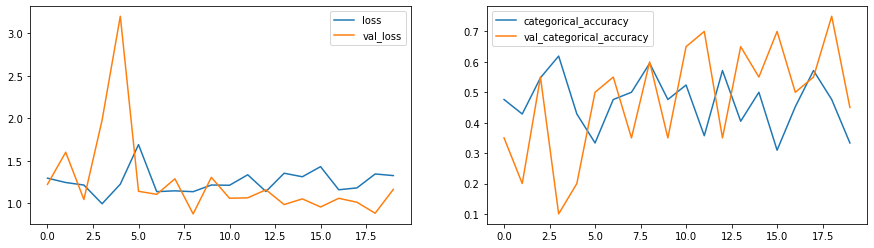

In [33]:
plot_score(history)



### Model with CNN + LSTM 


In [34]:

from keras.layers.convolutional import Conv2D, MaxPooling2D

from keras.layers.recurrent import LSTM , GRU
from keras.layers import TimeDistributed


In [35]:
        lstm_cells=128
        dense_neurons=128
        dropout=0.25
        frames_to_sample=30
        image_height=120
        image_width=120
        channels=3
        num_classes=5
        total_frames=30

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(frames_to_sample,image_height,image_width,channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(num_classes, activation='softmax'))
        #optimiser = tf.keras.optimizers.Adam()
        #model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [36]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 64)   



```
# This is formatted as code
```

### Experiment 9 - with CNN + LSTM  -  epoch =20 , batch size = 25 , learning_rate=0.0001

In [37]:
num_epochs = 20
batch_size =  25

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
27/27 [==============================] - 56s 2s/step - loss: 1.6883 - categorical_accuracy: 0.1975 - val_loss: 1.6072 - val_categorical_accuracy: 0.1500

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00001-1.68833-0.19753-1.60718-0.15000.h5
Epoch 2/20
27/27 [==============================] - 46s 2s/step - loss: 1.6210 - categorical_accuracy: 0.2840 - val_loss: 1.6184 - val_categorical_accuracy: 0.3250

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00002-1.62101-0.28395-1.61838-0.32500.h5
Epoch 3/20
27/27 [==============================] - 50s 2s/step - loss: 1.5315 - categorical_accuracy: 0.3457 - val_loss: 1.6303 - val_categorical_accuracy: 0.1500

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00003-1.53153-0.34568-1.63030-0.15000.h5

Epoch 00003: ReduceLROnPlateau

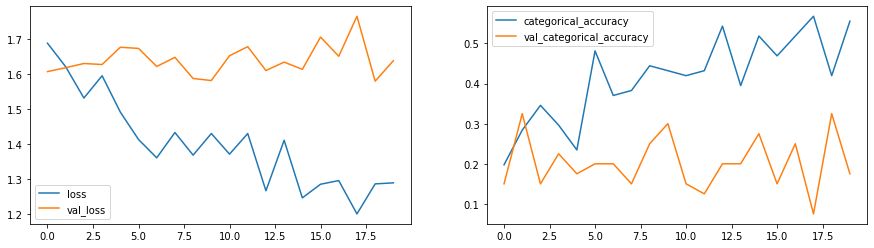

In [38]:
plot_score(history)

### Experiment 10 - with CNN + LSTM  -  epoch =20 , batch size = 50 , learning_rate=0.0001

In [39]:
num_epochs = 20
batch_size =  50

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
14/14 [==============================] - 27s 2s/step - loss: 1.2538 - categorical_accuracy: 0.5238 - val_loss: 1.6026 - val_categorical_accuracy: 0.4000

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00001-1.25382-0.52381-1.60260-0.40000.h5
Epoch 2/20
14/14 [==============================] - 27s 2s/step - loss: 1.3023 - categorical_accuracy: 0.4762 - val_loss: 1.7410 - val_categorical_accuracy: 0.1500

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00002-1.30234-0.47619-1.74101-0.15000.h5
Epoch 3/20
14/14 [==============================] - 29s 2s/step - loss: 1.2340 - categorical_accuracy: 0.5000 - val_loss: 1.7079 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00003-1.23400-0.50000-1.70791-0.20000.h5

Epoch 00003: ReduceLROnPlateau

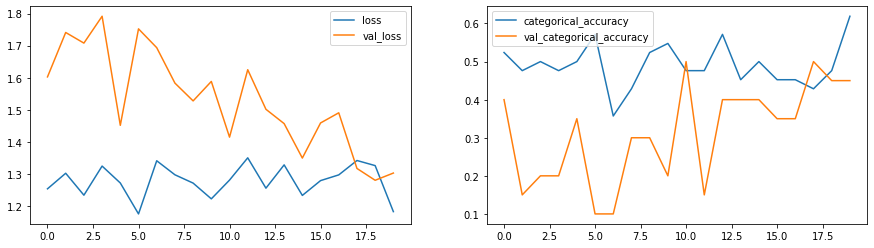

In [40]:
plot_score(history)

### Experiment 11 - with CNN + LSTM  -  epoch =20 , batch size = 50 , learning_rate=0.0002




In [41]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

num_epochs = 20
batch_size =  50

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
14/14 [==============================] - 30s 2s/step - loss: 1.4714 - categorical_accuracy: 0.4524 - val_loss: 1.5789 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00001-1.47138-0.45238-1.57894-0.25000.h5
Epoch 2/20
14/14 [==============================] - 26s 2s/step - loss: 1.4373 - categorical_accuracy: 0.4048 - val_loss: 1.6449 - val_categorical_accuracy: 0.1500

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00002-1.43735-0.40476-1.64493-0.15000.h5
Epoch 3/20
14/14 [==============================] - 27s 2s/step - loss: 1.4684 - categorical_accuracy: 0.3810 - val_loss: 1.6027 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00003-1.46841-0.38095-1.60271-0.30000.h5

Epoch 00003: ReduceLROnPlateau

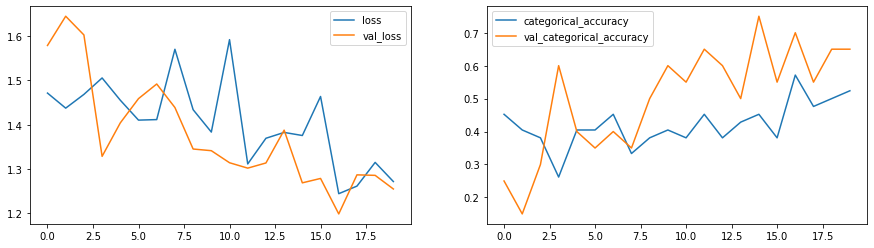

In [42]:
plot_score(history)

### Experiment 12 - with CNN + LSTM  -  epoch =20 , batch size = 25 , learning_rate=0.0002

In [43]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

num_epochs = 20
batch_size =  25

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
27/27 [==============================] - 57s 2s/step - loss: 1.3068 - categorical_accuracy: 0.4815 - val_loss: 1.7422 - val_categorical_accuracy: 0.1750

Epoch 00001: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00001-1.30678-0.48148-1.74221-0.17500.h5
Epoch 2/20
27/27 [==============================] - 48s 2s/step - loss: 1.3958 - categorical_accuracy: 0.3951 - val_loss: 1.4044 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00002-1.39575-0.39506-1.40441-0.50000.h5
Epoch 3/20
27/27 [==============================] - 46s 2s/step - loss: 1.4571 - categorical_accuracy: 0.3827 - val_loss: 1.5357 - val_categorical_accuracy: 0.2750

Epoch 00003: saving model to /content/drive/MyDrive/ML data /Project_data/model_init_2021-10-2718_28_08.014494/model-00003-1.45711-0.38272-1.53572-0.27500.h5
Epoch 4/20
27/27 [=============

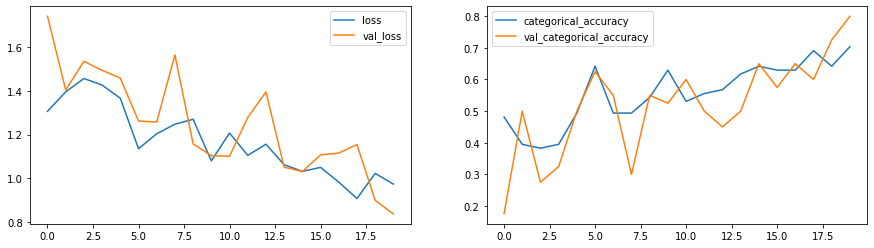

In [44]:
plot_score(history)